In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet import ResNet50
from sklearn.metrics import  classification_report
from keras.applications.imagenet_utils import preprocess_input

In [2]:

file_path = '/content/drive/MyDrive/Potatoo/train'



In [3]:
name_class = os.listdir(file_path)
name_class

['Potato Late blight', 'Potato Early blight', 'Potato Healthy']

In [4]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [5]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Potatoo/train/Potato La...,Potato Late blight
1,/content/drive/MyDrive/Potatoo/train/Potato He...,Potato Healthy
2,/content/drive/MyDrive/Potatoo/train/Potato La...,Potato Late blight
3,/content/drive/MyDrive/Potatoo/train/Potato La...,Potato Late blight
4,/content/drive/MyDrive/Potatoo/train/Potato Ea...,Potato Early blight


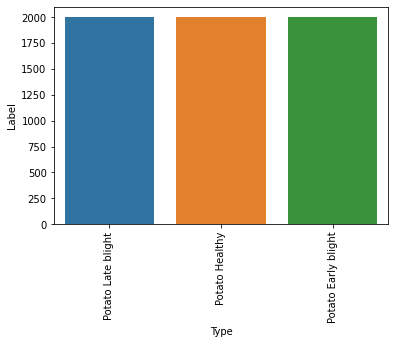

In [6]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [7]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

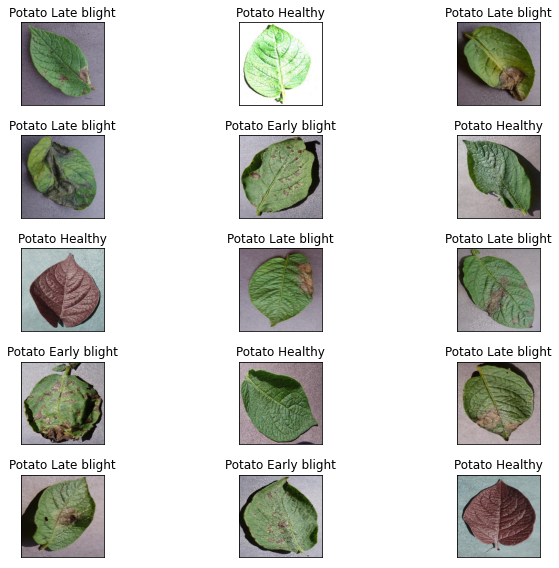

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [9]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 4800 validated image filenames belonging to 3 classes.
Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.


In [11]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [12]:


inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)



In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [15]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=4,
    callbacks=my_callbacks)




Epoch 1/4
75/75 [==============================] - 1719s 23s/step - loss: 0.2199 - accuracy: 0.9175 - val_loss: 0.0510 - val_accuracy: 0.9827
Epoch 2/4
75/75 [==============================] - 301s 4s/step - loss: 0.0533 - accuracy: 0.9800 - val_loss: 0.0539 - val_accuracy: 0.9790
Epoch 3/4
75/75 [==============================] - 302s 4s/step - loss: 0.0338 - accuracy: 0.9871 - val_loss: 0.0200 - val_accuracy: 0.9940
Epoch 4/4
75/75 [==============================] - 302s 4s/step - loss: 0.0197 - accuracy: 0.9929 - val_loss: 0.0081 - val_accuracy: 0.9990


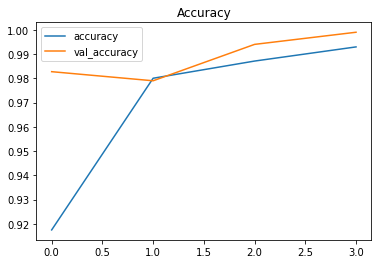

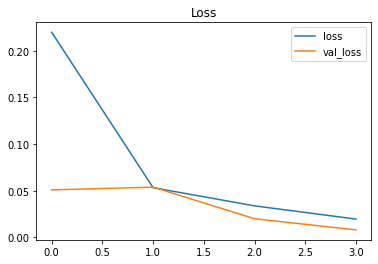

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04716
Test Accuracy: 98.08%


In [18]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

19/19 [==============================] - 39s 2s/step


In [19]:


y_test = list(test.Label)
print(classification_report(y_test, pred))



                     precision    recall  f1-score   support

Potato Early blight       0.97      0.99      0.98       399
     Potato Healthy       0.99      0.99      0.99       409
 Potato Late blight       0.98      0.96      0.97       392

           accuracy                           0.98      1200
          macro avg       0.98      0.98      0.98      1200
       weighted avg       0.98      0.98      0.98      1200



In [22]:
print(y_test)

['Potato Healthy', 'Potato Early blight', 'Potato Healthy', 'Potato Early blight', 'Potato Late blight', 'Potato Early blight', 'Potato Early blight', 'Potato Late blight', 'Potato Healthy', 'Potato Early blight', 'Potato Late blight', 'Potato Healthy', 'Potato Early blight', 'Potato Late blight', 'Potato Late blight', 'Potato Early blight', 'Potato Early blight', 'Potato Early blight', 'Potato Healthy', 'Potato Late blight', 'Potato Early blight', 'Potato Early blight', 'Potato Early blight', 'Potato Late blight', 'Potato Late blight', 'Potato Early blight', 'Potato Healthy', 'Potato Late blight', 'Potato Late blight', 'Potato Late blight', 'Potato Healthy', 'Potato Early blight', 'Potato Healthy', 'Potato Early blight', 'Potato Healthy', 'Potato Early blight', 'Potato Late blight', 'Potato Early blight', 'Potato Early blight', 'Potato Healthy', 'Potato Early blight', 'Potato Early blight', 'Potato Late blight', 'Potato Late blight', 'Potato Early blight', 'Potato Early blight', 'Pota

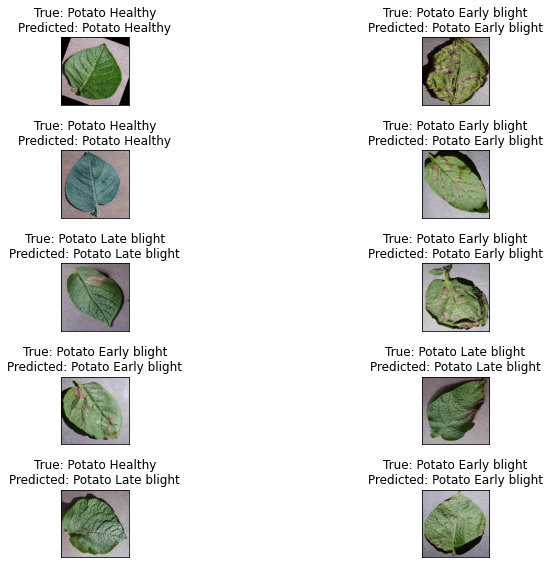

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [25]:
# Importing the dependancies
from sklearn import metrics
# Predicted values
y_pred = pred
# Actual values
y_act = y_test
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(y_act, y_pred, labels=["Potato Healthy","Potato Early blight","Potato Late blight" ]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=["Potato Healthy","Potato Early blight","Potato Late blight" ]))

[[406   0   3]
 [  0 394   5]
 [  4  11 377]]
                     precision    recall  f1-score   support

     Potato Healthy       0.99      0.99      0.99       409
Potato Early blight       0.97      0.99      0.98       399
 Potato Late blight       0.98      0.96      0.97       392

           accuracy                           0.98      1200
          macro avg       0.98      0.98      0.98      1200
       weighted avg       0.98      0.98      0.98      1200



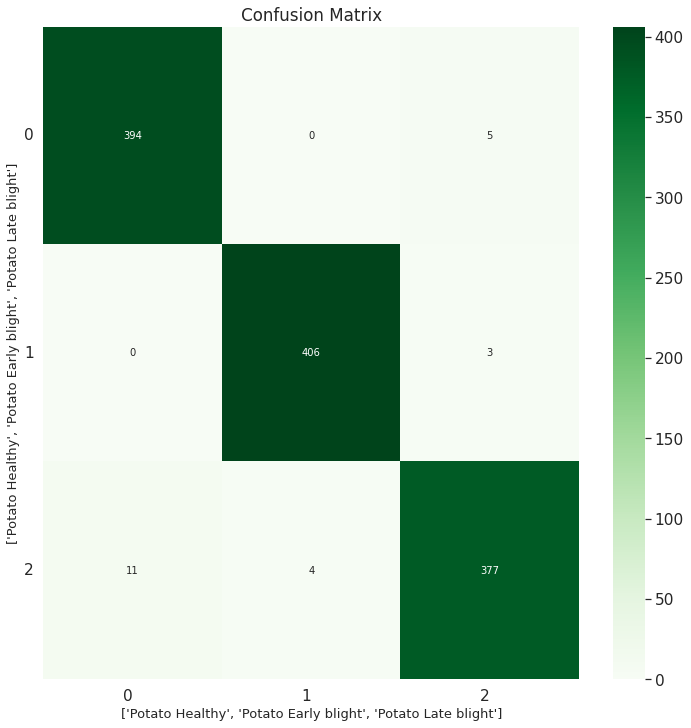

In [46]:
from sklearn.metrics import confusion_matrix
label = ["Potato Healthy","Potato Early blight","Potato Late blight"]
cm = confusion_matrix(y_test, pred)

fig = plt.figure(figsize=(12,12))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel(label,fontsize=13);ax.set_ylabel(label,fontsize=13); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='right')     
plt.show()
